In [2]:
# Load imports

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
import pandas as pd
metadata = pd.read_csv('archive/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Class distributions

In [4]:
print(metadata['class'].value_counts())

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [5]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

### Audio sample file properties

Next we will iterate through each of the audio sample files and extract, number of audio channels, sample rate and bit-depth. 

In [6]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display

wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath('archive/audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

### To convert mono audio to stereo audio

In [7]:
# num of channels 

print(audiodf.num_channels.value_counts(normalize=True))

num_channels
2    0.915369
1    0.084631
Name: proportion, dtype: float64


In [8]:
# sample rates 

print(audiodf.sample_rate.value_counts(normalize=True))

sample_rate
44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: proportion, dtype: float64


In [9]:
# bit depth

print(audiodf.bit_depth.value_counts(normalize=True))

bit_depth
16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: proportion, dtype: float64


In [10]:
import os
import numpy as np
import pandas as pd
import librosa
from concurrent.futures import ThreadPoolExecutor
from scipy.signal import butter, lfilter

fulldatasetpath = 'archive//audio/'

metadata = pd.read_csv('archive//UrbanSound8K.csv')

# Filtering Functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a


def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)


# Audio Processing Function
def process_audio_file(file_path, sample_rate):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Apply bandpass filtering (300 Hz - 8 kHz)
    filtered_audio = bandpass_filter(audio, lowcut=300, highcut=8000, fs=sr, order=5)

    # Feature Extraction
    # 1. MFCCs
    mfccs = librosa.feature.mfcc(y=filtered_audio, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)

    # 2. Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=filtered_audio))

    # 3. Root Mean Square Energy
    rmse = np.mean(librosa.feature.rms(y=filtered_audio))

    # Combine features into a single array
    features = np.concatenate(([zcr, rmse], mfccs))
    return features


# Load Audio Files and Create Features DataFrame
def load_audio_files_and_create_df(dataframe, sample_rate=22050, duration=5):
    features = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for index, row in dataframe.iterrows():
            file_path = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
            print(f"Processing file {index + 1}/{len(dataframe)}: {file_path}")
            futures.append(executor.submit(process_audio_file, file_path, sample_rate))

        for future, row in zip(futures, dataframe.itertuples(index=False)):
            features.append([future.result(), row.classID])

    # Convert into a Pandas DataFrame
    featuresdf = pd.DataFrame(features, columns=['feature', 'class_label'])
    return featuresdf


# Assuming `metadata` DataFrame is already loaded
featuresdf = load_audio_files_and_create_df(metadata)

# Print the resulting DataFrame and its length
print(featuresdf)
print('Finished feature extraction from ', len(featuresdf), ' files')


Processing file 1/8732: g:\archive\audio\fold5/100032-3-0-0.wav
Processing file 2/8732: g:\archive\audio\fold5/100263-2-0-117.wav
Processing file 3/8732: g:\archive\audio\fold5/100263-2-0-121.wav
Processing file 4/8732: g:\archive\audio\fold5/100263-2-0-126.wav
Processing file 5/8732: g:\archive\audio\fold5/100263-2-0-137.wav
Processing file 6/8732: g:\archive\audio\fold5/100263-2-0-143.wav
Processing file 7/8732: g:\archive\audio\fold5/100263-2-0-161.wav
Processing file 8/8732: g:\archive\audio\fold5/100263-2-0-3.wav
Processing file 9/8732: g:\archive\audio\fold5/100263-2-0-36.wav
Processing file 10/8732: g:\archive\audio\fold10/100648-1-0-0.wav
Processing file 11/8732: g:\archive\audio\fold10/100648-1-1-0.wav
Processing file 12/8732: g:\archive\audio\fold10/100648-1-2-0.wav
Processing file 13/8732: g:\archive\audio\fold10/100648-1-3-0.wav
Processing file 14/8732: g:\archive\audio\fold10/100648-1-4-0.wav
Processing file 15/8732: g:\archive\audio\fold2/100652-3-0-0.wav
Processing file 

g:\Semester\Signal and Systems\UsamaProvided\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
g:\Semester\Signal and Systems\UsamaProvided\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
g:\Semester\Signal and Systems\UsamaProvided\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


                                                feature  class_label
0     [0.12517438616071427, 0.12639565765857697, -24...            3
1     [0.19869942196531792, 0.002851941389963031, -4...            2
2     [0.17000654804913296, 0.001812343136407435, -5...            2
3     [0.18317320718930635, 0.0034522423520684242, -...            2
4     [0.19709627890173412, 0.0019610938616096973, -...            2
...                                                 ...          ...
8727  [0.14722667539739884, 0.0037090841215103865, -...            1
8728  [0.24840389784946237, 0.014440629631280899, -3...            1
8729  [0.14763878828642385, 0.011131590232253075, -3...            1
8730  [0.17218409547018348, 0.007923971861600876, -3...            1
8731  [0.19318914850917432, 0.009610041975975037, -3...            1

[8732 rows x 2 columns]
Finished feature extraction from  8732  files


### Convert the data and labels

We will use `sklearn.preprocessing.LabelEncoder` to encode the categorical text data into model-understandable numerical data. 

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features to a consistent 40-dimensional array
X = np.array([np.array(xi) for xi in featuresdf.feature])


# Encode the labels
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


In [12]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [13]:
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('yy.npy', yy)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(42,)))

model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(num_labels))
model.add(Activation('softmax'))

print(x_train.shape[1])

g:\Semester\Signal and Systems\UsamaProvided\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42


In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [16]:
# # Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,370 (310.04 KB)

 Trainable params: 79,370 (310.04 KB)

 Non-trainable params: 0 (0.00 B)

Pre-training accuracy: 7.5558%


In [17]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='archive/saved_models/model.keras', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history= model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
216/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1565 - loss: 20.5104
Epoch 1: val_loss improved from inf to 2.16381, saving model to archive/saved_models/model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1570 - loss: 20.3112 - val_accuracy: 0.2421 - val_loss: 2.1638
Epoch 2/100
213/219 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2178 - loss: 2.4054
Epoch 2: val_loss improved from 2.16381 to 2.05888, saving model to archive/saved_models/model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2181 - loss: 2.4015 - val_accuracy: 0.2828 - val_loss: 2.0589
Epoch 3/100
210/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2609 - loss: 2.0880
Epoch 3: val_loss improved from 2.05888 to 1.87793, saving model to archive/saved_models/model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2611 - loss: 2.0867 - val_accuracy: 0.3578 - val_loss: 1.8779
Epoch 4/100
211/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3169 - loss: 1.9428

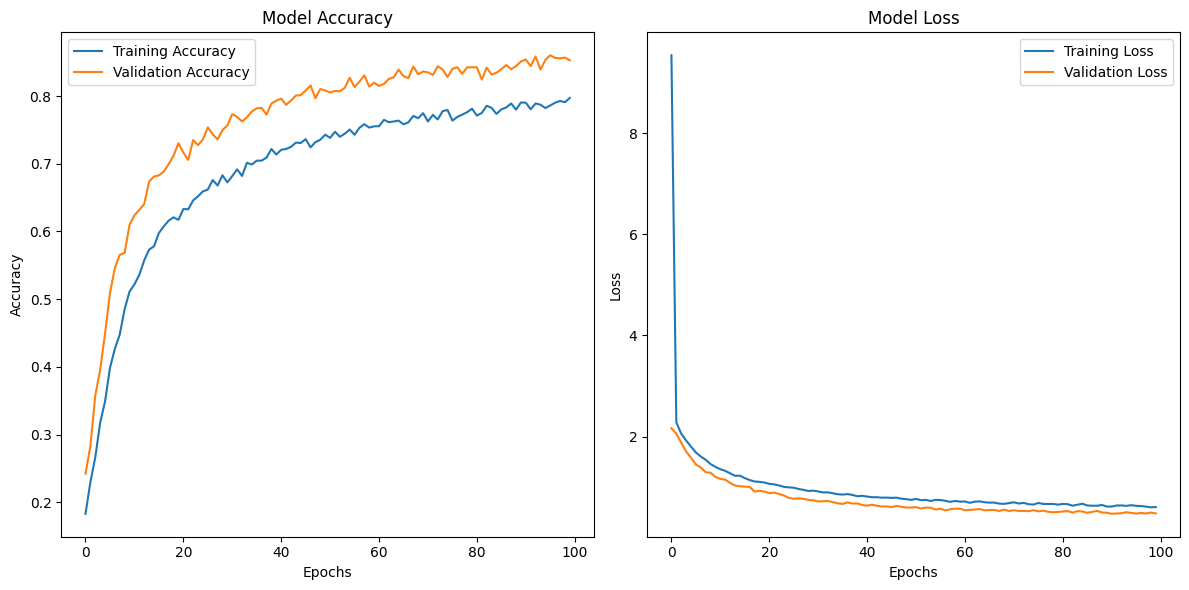

In [18]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable returned by model.fit
# For example:
# history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

# Plot Accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [19]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])



Training Accuracy:  0.9056549668312073
Testing Accuracy:  0.85289067029953


In [28]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from scipy.signal import butter, lfilter

# Function to load the trained model
def load_trained_model(model_path):
    return load_model(model_path)

# Filtering Functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Audio Processing
def process_audio_file(file_path, sample_rate=22050):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Apply bandpass filtering (300 Hz - 8 kHz)
    filtered_audio = bandpass_filter(audio, lowcut=300, highcut=8000, fs=sr, order=5)

    # Feature Extraction
    # 1. MFCCs
    mfccs = librosa.feature.mfcc(y=filtered_audio, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)

    # 2. Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=filtered_audio))

    # 3. Root Mean Square Energy
    rmse = np.mean(librosa.feature.rms(y=filtered_audio))

    # Combine features into a single array
    features = np.concatenate(([zcr, rmse], mfccs))
    return features

# Function to predict the class of an audio file
def predict_audio_class(audio_file, model, label_encoder, sample_rate=22050):
    # Process the audio file to extract features
    features = process_audio_file(audio_file, sample_rate)

    # Reshape for model input
    features = features.reshape(1, -1)

    # Predict using the trained model
    predictions = model.predict(features)

    # Decode the prediction
    predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])

    return predicted_class[0], predictions

# Function to map predicted class to category
def map_class_to_category(predicted_class):
    # Define the mapping of classes to categories
    class_to_category = {
        'dog_bark': 'Speech',
        'children_playing': 'Speech',
        'air_conditioner': 'Noise',
        'car_horn': 'Noise',
        'drilling': 'Noise',
        'engine_drilling': 'Noise',
        'gun_shot': 'Noise',
        'jackhammer': 'Noise',
        'siren': 'Noise',
        'street_music': 'Music',
    }

    # Return the category for the predicted class
    return class_to_category.get(predicted_class, 'Unknown')

# Load the trained model
model = load_trained_model('archive/saved_models/model.keras')

# Refitting the LabelEncoder (if you don't have it saved, use the training labels)
y_train_labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_drilling', 'gun_shot', 'jackhammer', 'siren', 'street_music']  # Replace with actual class labels from your training data
label_encoder = LabelEncoder()
label_encoder.fit(y_train_labels)

# Example of predicting class of a new audio file
audio_file = 'archive/audio/fold10/100795-3-0-0.wav'  # Replace with the path to the audio file you want to predict
predicted_class, predictions = predict_audio_class(audio_file, model, label_encoder)

# Print the predicted class and its corresponding category
category = map_class_to_category(predicted_class)
print(f"The predicted class of the audio is: {predicted_class}")
print(f"The predicted class belongs to the category: {category}")

# Print all prediction probabilities
print("Prediction probabilities for each class:")
for class_label, probability in zip(label_encoder.classes_, predictions[0]):
    print(f"{class_label}: {probability:.20f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
The predicted class of the audio is: dog_bark
The predicted class belongs to the category: Speech
Prediction probabilities for each class:
air_conditioner: 0.00000000000000000137
car_horn: 0.00000000000002035758
children_playing: 0.00019723029981832951
dog_bark: 0.99643862247467041016
drilling: 0.00000058050000006915
engine_drilling: 0.00000000000003633953
gun_shot: 0.00258106132969260216
jackhammer: 0.00000000000000000000
siren: 0.00078248098725453019
street_music: 0.00000000472053462985


Generating spectrogram...


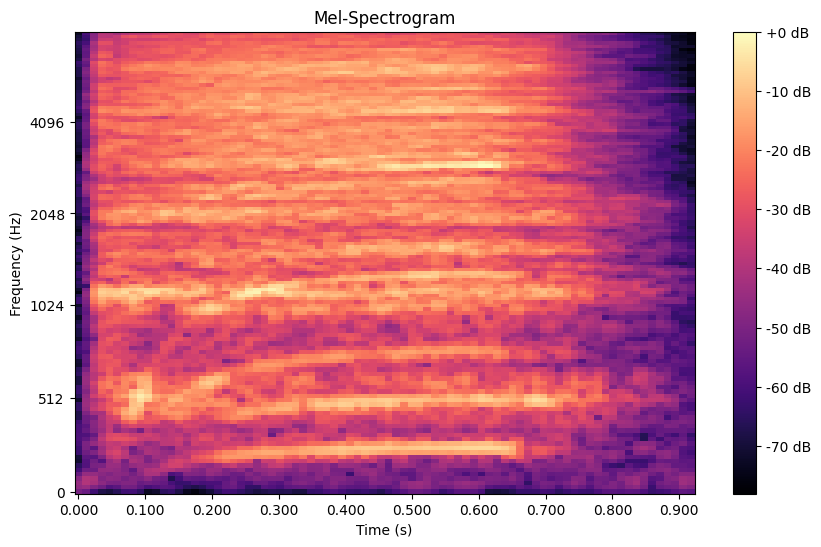

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Function to plot the spectrogram
def plot_spectrogram(audio, sr):
    plt.figure(figsize=(10, 6))
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()



# Example usage (replace 'your_audio_file.wav' with an actual file)
audio_path =  'archive/audio/fold7/135849-4-0-0.wav' 
audio, sr = librosa.load(audio_path, sr=None)
filtered_audio = librosa.effects.harmonic(audio)

# Plotting
print("Generating spectrogram...")
plot_spectrogram(filtered_audio, sr)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


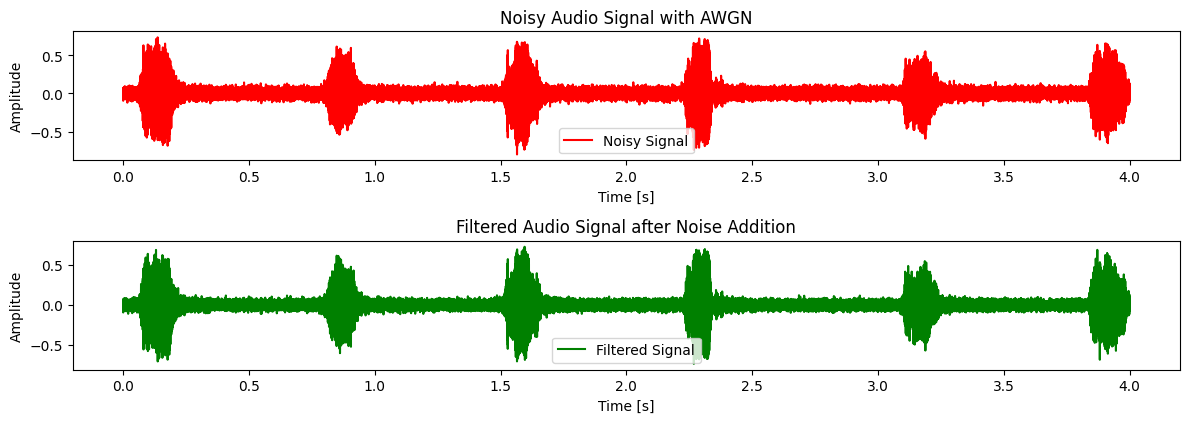

The predicted class of the noisy audio is: dog_bark
The predicted class belongs to the category: Speech


In [27]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from scipy.signal import butter, lfilter

# Function to load the trained model
def load_trained_model(model_path):
    return load_model(model_path)

# Filtering Functions (same as in your code)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data)

# Audio Processing (same as in your code)
def process_audio_file_with_noise(file_path, snr_db=10, sample_rate=22050):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Add AWGN noise to the signal
    noisy_audio = add_awgn_noise(audio, snr_db)

    # Apply bandpass filtering (300 Hz - 8 kHz)
    filtered_audio = bandpass_filter(noisy_audio, lowcut=300, highcut=8000, fs=sr, order=5)

    # Feature Extraction
    # 1. MFCCs
    mfccs = librosa.feature.mfcc(y=filtered_audio, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)

    # 2. Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=filtered_audio))

    # 3. Root Mean Square Energy
    rmse = np.mean(librosa.feature.rms(y=filtered_audio))

    # Combine features into a single array
    features = np.concatenate(([zcr, rmse], mfccs))
    return features, noisy_audio, filtered_audio, sr

# Function to add AWGN noise to the signal
def add_awgn_noise(signal, snr_db):
    # Calculate signal power
    signal_power = np.mean(signal ** 2)
    
    # Calculate noise power
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Generate Gaussian noise
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    
    # Add noise to the signal
    noisy_signal = signal + noise
    return noisy_signal

# Function to map predicted class to category
def map_class_to_category(predicted_class):
    # Define the mapping of classes to categories
    class_to_category = {
        'dog_bark': 'Speech',
        'children_playing': 'Speech',
        'air_conditioner': 'Noise',
        'car_horn': 'Noise',
        'drilling': 'Noise',
        'engine_drilling': 'Noise',
        'gun_shot': 'Noise',
        'jackhammer': 'Noise',
        'siren': 'Noise',
        'street_music': 'Music',
    }

    # Return the category for the predicted class
    return class_to_category.get(predicted_class, 'Unknown')

# Function to predict the class of an audio file
def predict_audio_class(audio_file, model, label_encoder, snr_db=5, sample_rate=22050):
    # Process the audio file to extract features (with noise addition and filtering)
    features, noisy_audio, filtered_audio, sr = process_audio_file_with_noise(audio_file, snr_db, sample_rate)

    # Reshape features for model input
    features = features.reshape(1, -1)

    # Predict using the trained model
    prediction = model.predict(features)

    # Decode the prediction
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    # Map the predicted class to category
    category = map_class_to_category(predicted_class[0])

    # Plot the original, noisy, and filtered signals
    plot_signals(noisy_audio, filtered_audio, sr)

    return predicted_class[0], category

# Function to plot original, noisy, and filtered signals
def plot_signals(noisy_signal, filtered_signal, sample_rate):
    # Create time axis for plotting
    time = np.arange(0, len(noisy_signal)) / sample_rate

    plt.figure(figsize=(12, 6))

    # Plot noisy signal
    plt.subplot(3, 1, 1)
    plt.plot(time, noisy_signal, label='Noisy Signal', color='r')
    plt.title('Noisy Audio Signal with AWGN')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot filtered signal
    plt.subplot(3, 1, 2)
    plt.plot(time, filtered_signal, label='Filtered Signal', color='g')
    plt.title('Filtered Audio Signal after Noise Addition')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load the trained model
model = load_trained_model('archive/saved_models/model.keras')

# Refitting the LabelEncoder (if you don't have it saved, use the training labels)
# Assuming you have the original labels for training
# For example:
y_train_labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_drilling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
label_encoder = LabelEncoder()
label_encoder.fit(y_train_labels)

# Example of predicting class of a new audio file with noise
audio_file = 'archive/audio/fold10/100795-3-0-0.wav'  # Replace with the path to the audio file you want to predict
snr_db = 10  # Signal-to-noise ratio in dB
predicted_class, category = predict_audio_class(audio_file, model, label_encoder, snr_db)

# Print the predicted class and its corresponding category
print(f"The predicted class of the noisy audio is: {predicted_class}")
print(f"The predicted class belongs to the category: {category}")


In [23]:


import librosa
import sounddevice as sd

# Function to play audio using librosa
def play_audio(file_path):
    # Load audio file using librosa
    audio_data, sample_rate = librosa.load(file_path, sr=None)  # sr=None preserves the original sample rate
    
    # Play the audio using sounddevice
    sd.play(audio_data, sample_rate)
    
    # Wait until the audio finishes playing
    sd.wait()

# Example usage
audio_file = 'archive/audio/fold6/133797-6-1-0.wav'  # Replace with the actual file path
play_audio(audio_file)


In [24]:
import matplotlib.pyplot as plt
from IPython.display import Audio
audio_file_path = 'archive/audio/fold2/100652-3-0-1.wav' 
audio_data, sample_rate = librosa.load(audio_file_path, sr=None)

Audio(audio_file_path)
